# Texas EDA with the 2016 Presidential Election

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, countDistinct, round, when, translate, max, min
from pyspark.sql.functions import isnull, isnan, count

In [2]:
bucket_dir = 'gs://pstat135-voter-file/VM2Uniform/'
FL_fulldf = spark.read.parquet(bucket_dir + 'VM2Uniform--FL--2021-05-19')

In [3]:
keep = ['LALVOTERID', 'County', 'Board_of_Education_District', 'County_Board_of_Education_District', 'CommercialData_Education',
        'CommercialData_AreaMedianEducationYears', 'CommercialDataLL_Interest_in_Education_Online_In_Household',
        'ElectionReturns_G16_Cnty_Margin_Clinton_D', 'ElectionReturns_G16_Cnty_Percent_Clinton_D', 
        'ElectionReturns_G16_Cnty_Vote_Clinton_D', 'ElectionReturns_G16_Cnty_Margin_Trump_R',
        'ElectionReturns_G16_Cnty_Percent_Trump_R', 'ElectionReturns_G16_Cnty_Vote_Trump_R',
        'ElectionReturns_G16CountyTurnoutAllRegisteredVoters', 'ElectionReturns_G16CountyTurnoutDemocrats',
        'ElectionReturns_G16CountyTurnoutIndependentsAllOthers', 'ElectionReturns_G16CountyTurnoutRepublicans']
FL_df = FL_fulldf.select(keep)

In [4]:
total_state_voters_FL = FL_df.select(countDistinct('LALVOTERID'))
total_state_voters_FL.show()

+--------------------------+
|count(DISTINCT LALVOTERID)|
+--------------------------+
|                  14168189|
+--------------------------+



<AxesSubplot:>

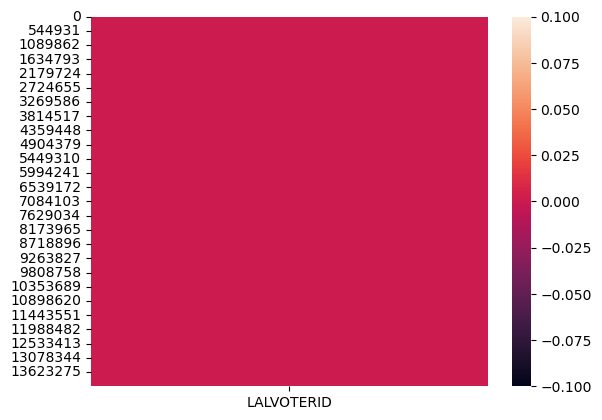

In [5]:
ID_list = FL_df.select('LALVOTERID')
ID_list_pd = ID_list.toPandas()
# Convert all values to T/F
ID_tf = ID_list_pd.isnull()
# Plot it
sns.heatmap(data=ID_tf)

In [6]:
num_counties_FL = FL_df.select(countDistinct('County'))
num_counties_FL.show()

+----------------------+
|count(DISTINCT County)|
+----------------------+
|                    67|
+----------------------+



<AxesSubplot:>

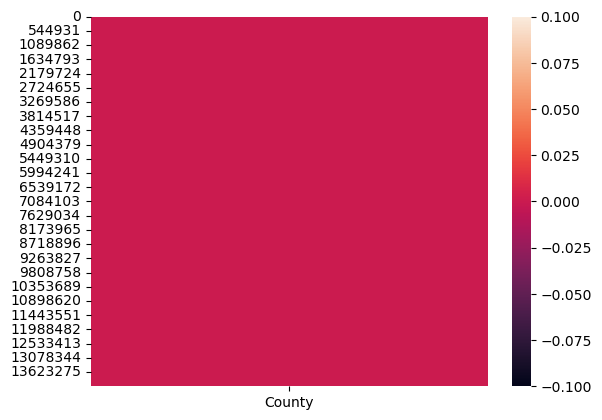

In [7]:
county_list = FL_df.select('County')
county_list_pd = county_list.toPandas()
# Convert all values to T/F
county_tf = county_list_pd.isnull()
# Plot it
sns.heatmap(data=county_tf)

In [8]:
FL_df = FL_df.withColumnRenamed("ElectionReturns_G16CountyTurnoutAllRegisteredVoters", "CountyTurnoutAll") \
    .withColumnRenamed("ElectionReturns_G16CountyTurnoutDemocrats", "CountyTurnoutDem") \
    .withColumnRenamed("ElectionReturns_G16CountyTurnoutIndependentsAllOthers", "CountyTurnoutOther") \
    .withColumnRenamed("ElectionReturns_G16CountyTurnoutRepublicans", "CountyTurnoutRep")
cty_voter_turnout_FL = FL_df.select('County', 'CountyTurnoutAll', 'CountyTurnoutDem',
                                'CountyTurnoutOther', 'CountyTurnoutRep').distinct().orderBy('County') # unique values per each county
cty_voter_turnout_FL.show()

+---------+----------------+----------------+------------------+----------------+
|   County|CountyTurnoutAll|CountyTurnoutDem|CountyTurnoutOther|CountyTurnoutRep|
+---------+----------------+----------------+------------------+----------------+
|  ALACHUA|             74%|             78%|               57%|             81%|
|    BAKER|             84%|             83%|               60%|             90%|
|      BAY|             75%|             74%|               54%|             85%|
| BRADFORD|             76%|             76%|               55%|             84%|
|  BREVARD|             78%|             79%|               63%|             86%|
|  BROWARD|             72%|             76%|               59%|             78%|
|  CALHOUN|             72%|             74%|               46%|             78%|
|CHARLOTTE|             76%|             78%|               62%|             84%|
|   CITRUS|             77%|             77%|               62%|             84%|
|     CLAY|     

In [9]:
cty_voter_turnout_FL = cty_voter_turnout_FL.withColumn('CountyTurnoutPrcnt', translate(col('CountyTurnoutAll'),'%', ''))\
                    .withColumn('CountyTurnoutPrcntDem', translate(col('CountyTurnoutDem'),'%', ''))\
                    .withColumn('CountyTurnoutPrcntRep', translate(col('CountyTurnoutRep'),'%', ''))\
                    .withColumn('CountyTurnoutPrcntOther', translate(col('CountyTurnoutOther'),'%', ''))\
                    .drop('CountyTurnoutAll', 'CountyTurnoutDem', 'CountyTurnoutRep', 'CountyTurnoutOther')

from pyspark.sql.types import IntegerType
voter_turnout_FL_CLEAN = cty_voter_turnout_FL.withColumn('CountyTurnoutInt', cty_voter_turnout_FL['CountyTurnoutPrcnt'].cast(IntegerType()))\
                        .withColumn('CountyTurnoutDemInt', cty_voter_turnout_FL['CountyTurnoutPrcntDem'].cast(IntegerType()))\
                        .withColumn('CountyTurnoutRepInt', cty_voter_turnout_FL['CountyTurnoutPrcntRep'].cast(IntegerType()))\
                        .withColumn('CountyTurnoutOtherInt', cty_voter_turnout_FL['CountyTurnoutPrcntOther'].cast(IntegerType()))\
                        .drop('CountyTurnoutPrcnt', 'CountyTurnoutPrcntDem', 'CountyTurnoutPrcntRep', 'CountyTurnoutPrcntOther')
voter_turnout_FL_CLEAN.show()

+---------+----------------+-------------------+-------------------+---------------------+
|   County|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|
+---------+----------------+-------------------+-------------------+---------------------+
|  ALACHUA|              74|                 78|                 81|                   57|
|    BAKER|              84|                 83|                 90|                   60|
|      BAY|              75|                 74|                 85|                   54|
| BRADFORD|              76|                 76|                 84|                   55|
|  BREVARD|              78|                 79|                 86|                   63|
|  BROWARD|              72|                 76|                 78|                   59|
|  CALHOUN|              72|                 74|                 78|                   46|
|CHARLOTTE|              76|                 78|                 84|                   62|

In [10]:
voter_turnout_FL_CLEAN.select(max('CountyTurnoutInt'), max('CountyTurnoutDemInt'), max('CountyTurnoutRepInt'), max('CountyTurnoutOtherInt')).show()
voter_turnout_FL_CLEAN.select(min('CountyTurnoutInt'), min('CountyTurnoutDemInt'), min('CountyTurnoutRepInt'), min('CountyTurnoutOtherInt')).show()

+---------------------+------------------------+------------------------+--------------------------+
|max(CountyTurnoutInt)|max(CountyTurnoutDemInt)|max(CountyTurnoutRepInt)|max(CountyTurnoutOtherInt)|
+---------------------+------------------------+------------------------+--------------------------+
|                   87|                      89|                      93|                        75|
+---------------------+------------------------+------------------------+--------------------------+



+---------------------+------------------------+------------------------+--------------------------+
|min(CountyTurnoutInt)|min(CountyTurnoutDemInt)|min(CountyTurnoutRepInt)|min(CountyTurnoutOtherInt)|
+---------------------+------------------------+------------------------+--------------------------+
|                   64|                      64|                      75|                        39|
+---------------------+------------------------+------------------------+--------------------------+



In [11]:
FL_turnout_max_min = voter_turnout_FL_CLEAN.filter((col('CountyTurnoutInt')==86) | (col('CountyTurnoutInt')==73))
FL_turnout_max_min.show()

+--------+----------------+-------------------+-------------------+---------------------+
|  County|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|
+--------+----------------+-------------------+-------------------+---------------------+
|   DIXIE|              73|                 73|                 82|                   52|
|HERNANDO|              73|                 73|                 82|                   59|
|    LEVY|              73|                 72|                 82|                   53|
| OSCEOLA|              73|                 78|                 88|                   56|
|   PASCO|              73|                 74|                 82|                   60|
| VOLUSIA|              73|                 75|                 83|                   59|
|  WALTON|              73|                 70|                 80|                   54|
+--------+----------------+-------------------+-------------------+---------------------+



In [12]:
FL_dem_turnout_max_min = voter_turnout_FL_CLEAN.filter((col('CountyTurnoutDemInt')==100) | (col('CountyTurnoutDemInt')==88))
FL_dem_turnout_max_min.show()

+------+----------------+-------------------+-------------------+---------------------+
|County|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|
+------+----------------+-------------------+-------------------+---------------------+
+------+----------------+-------------------+-------------------+---------------------+



In [13]:
FL_rep_turnout_max_min = voter_turnout_FL_CLEAN.filter((col('CountyTurnoutRepInt')==100) | (col('CountyTurnoutRepInt')==94))
FL_rep_turnout_max_min.show()
FL_rep_turnout_max_min.filter(col('CountyTurnoutRepInt')==100).count()

+------+----------------+-------------------+-------------------+---------------------+
|County|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|
+------+----------------+-------------------+-------------------+---------------------+
+------+----------------+-------------------+-------------------+---------------------+



0

In [14]:
FL_other_turnout_max_min = voter_turnout_FL_CLEAN.filter((col('CountyTurnoutOtherInt')==64) | (col('CountyTurnoutOtherInt')==46))
FL_other_turnout_max_min.show()

+-------+----------------+-------------------+-------------------+---------------------+
| County|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|
+-------+----------------+-------------------+-------------------+---------------------+
|CALHOUN|              72|                 74|                 78|                   46|
|JACKSON|              74|                 75|                 79|                   46|
|   LAKE|              78|                 78|                 86|                   64|
| MARTIN|              79|                 79|                 86|                   64|
+-------+----------------+-------------------+-------------------+---------------------+



In [15]:
FL_df = FL_df.withColumnRenamed("ElectionReturns_G16_Cnty_Percent_Clinton_D", "Cnty_Percent_D") \
    .withColumnRenamed("ElectionReturns_G16_Cnty_Vote_Clinton_D", "Cnty_Vote_D") \
    .withColumnRenamed("ElectionReturns_G16_Cnty_Percent_Trump_R", "Cnty_Percent_R") \
    .withColumnRenamed("ElectionReturns_G16_Cnty_Vote_Trump_R", "Cnty_Vote_R")
election_results_FL = FL_df.select('County',
                                   'Cnty_Percent_D', 
                                   'Cnty_Vote_D',
                                   'Cnty_Percent_R', 
                                   'Cnty_Vote_R').distinct().orderBy('County')
election_results_FL.show()

+---------+--------------+-----------+--------------+-----------+
|   County|Cnty_Percent_D|Cnty_Vote_D|Cnty_Percent_R|Cnty_Vote_R|
+---------+--------------+-----------+--------------+-----------+
|  ALACHUA|           58%|      75820|           36%|      46834|
|    BAKER|           17%|       2112|           81%|      10294|
|      BAY|           25%|      21797|           71%|      62194|
| BRADFORD|           24%|       2924|           73%|       8913|
|  BREVARD|           38%|     119679|           57%|     181848|
|  BROWARD|           66%|     553320|           31%|     260951|
|  CALHOUN|           20%|       1241|           76%|       4655|
|CHARLOTTE|           34%|      33445|           62%|      60218|
|   CITRUS|           28%|      22789|           68%|      54456|
|     CLAY|           26%|      27822|           70%|      74963|
|  COLLIER|           35%|      61085|           61%|     105423|
| COLUMBIA|           26%|       7601|           71%|      20368|
|   DESOTO

In [16]:
election_results_FL = election_results_FL.withColumn('Cnty_Prcnt_D', translate(col('Cnty_Percent_D'),'%', ''))\
                    .withColumn('Cnty_Prcnt_R', translate(col('Cnty_Percent_R'),'%', ''))\
                    .drop('Cnty_Percent_D', 'Cnty_Percent_R')

election_results_FL_CLEAN = election_results_FL.withColumn('Cnty_Prcnt_D_Int', election_results_FL['Cnty_Prcnt_D'].cast(IntegerType()))\
                        .withColumn('Cnty_Prcnt_R_Int', election_results_FL['Cnty_Prcnt_R'].cast(IntegerType()))\
                        .withColumn('Cnty_Vote_D_Int', election_results_FL['Cnty_Vote_D'].cast(IntegerType()))\
                        .withColumn('Cnty_Vote_R_Int', election_results_FL['Cnty_Vote_R'].cast(IntegerType()))\
                        .drop('Cnty_Prcnt_D', 'Cnty_Prcnt_R', 'Cnty_Vote_D', 'Cnty_Vote_R')
election_results_FL_CLEAN.show()

+---------+----------------+----------------+---------------+---------------+
|   County|Cnty_Prcnt_D_Int|Cnty_Prcnt_R_Int|Cnty_Vote_D_Int|Cnty_Vote_R_Int|
+---------+----------------+----------------+---------------+---------------+
|  ALACHUA|              58|              36|          75820|          46834|
|    BAKER|              17|              81|           2112|          10294|
|      BAY|              25|              71|          21797|          62194|
| BRADFORD|              24|              73|           2924|           8913|
|  BREVARD|              38|              57|         119679|         181848|
|  BROWARD|              66|              31|         553320|         260951|
|  CALHOUN|              20|              76|           1241|           4655|
|CHARLOTTE|              34|              62|          33445|          60218|
|   CITRUS|              28|              68|          22789|          54456|
|     CLAY|              26|              70|          27822|   

In [17]:
election_results_FL_CLEAN.select(max('Cnty_Prcnt_D_Int'), max('Cnty_Prcnt_R_Int')).show()
election_results_FL_CLEAN.select(min('Cnty_Prcnt_D_Int'), min('Cnty_Prcnt_R_Int')).show()

+---------------------+---------------------+
|max(Cnty_Prcnt_D_Int)|max(Cnty_Prcnt_R_Int)|
+---------------------+---------------------+
|                   68|                   87|
+---------------------+---------------------+



+---------------------+---------------------+
|min(Cnty_Prcnt_D_Int)|min(Cnty_Prcnt_R_Int)|
+---------------------+---------------------+
|                   10|                   30|
+---------------------+---------------------+



In [18]:
FL_D_Prcnt_max_min = election_results_FL_CLEAN.filter((col('Cnty_Prcnt_D_Int')==73) | (col('Cnty_Prcnt_D_Int')==16))
FL_D_Prcnt_max_min.show()
FL_R_Prcnt_max_min = election_results_FL_CLEAN.filter((col('Cnty_Prcnt_R_Int')==77) | (col('Cnty_Prcnt_R_Int')==17))
FL_R_Prcnt_max_min.show()

+------+----------------+----------------+---------------+---------------+
|County|Cnty_Prcnt_D_Int|Cnty_Prcnt_R_Int|Cnty_Vote_D_Int|Cnty_Vote_R_Int|
+------+----------------+----------------+---------------+---------------+
+------+----------------+----------------+---------------+---------------+



+----------+----------------+----------------+---------------+---------------+
|    County|Cnty_Prcnt_D_Int|Cnty_Prcnt_R_Int|Cnty_Vote_D_Int|Cnty_Vote_R_Int|
+----------+----------------+----------------+---------------+---------------+
|   LIBERTY|              20|              77|            651|           2543|
|WASHINGTON|              20|              77|           2264|           8637|
+----------+----------------+----------------+---------------+---------------+



In [19]:
FL_turnout_max_min = voter_turnout_FL_CLEAN.filter((col('CountyTurnoutInt')==86) | (col('CountyTurnoutInt')==73))
FL_turnout_max_min.show()

+--------+----------------+-------------------+-------------------+---------------------+
|  County|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|
+--------+----------------+-------------------+-------------------+---------------------+
|   DIXIE|              73|                 73|                 82|                   52|
|HERNANDO|              73|                 73|                 82|                   59|
|    LEVY|              73|                 72|                 82|                   53|
| OSCEOLA|              73|                 78|                 88|                   56|
|   PASCO|              73|                 74|                 82|                   60|
| VOLUSIA|              73|                 75|                 83|                   59|
|  WALTON|              73|                 70|                 80|                   54|
+--------+----------------+-------------------+-------------------+---------------------+



In [20]:
FL_dem_turnout_max_min = voter_turnout_FL_CLEAN.filter((col('CountyTurnoutDemInt')==100) | (col('CountyTurnoutDemInt')==88))
FL_dem_turnout_max_min.show()

+------+----------------+-------------------+-------------------+---------------------+
|County|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|
+------+----------------+-------------------+-------------------+---------------------+
+------+----------------+-------------------+-------------------+---------------------+



In [21]:
FL_rep_turnout_max_min = voter_turnout_FL_CLEAN.filter((col('CountyTurnoutRepInt')==100) | (col('CountyTurnoutRepInt')==94))
FL_rep_turnout_max_min.show()
FL_rep_turnout_max_min.filter(col('CountyTurnoutRepInt')==100).count()

+------+----------------+-------------------+-------------------+---------------------+
|County|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|
+------+----------------+-------------------+-------------------+---------------------+
+------+----------------+-------------------+-------------------+---------------------+



0

In [22]:
FL_other_turnout_max_min = voter_turnout_FL_CLEAN.filter((col('CountyTurnoutOtherInt')==64) | (col('CountyTurnoutOtherInt')==46))
FL_other_turnout_max_min.show()

+-------+----------------+-------------------+-------------------+---------------------+
| County|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|
+-------+----------------+-------------------+-------------------+---------------------+
|CALHOUN|              72|                 74|                 78|                   46|
|JACKSON|              74|                 75|                 79|                   46|
|   LAKE|              78|                 78|                 86|                   64|
| MARTIN|              79|                 79|                 86|                   64|
+-------+----------------+-------------------+-------------------+---------------------+



In [23]:
FL_df = FL_df.withColumnRenamed("ElectionReturns_G16_Cnty_Percent_Clinton_D", "Cnty_Percent_D") \
    .withColumnRenamed("ElectionReturns_G16_Cnty_Vote_Clinton_D", "Cnty_Vote_D") \
    .withColumnRenamed("ElectionReturns_G16_Cnty_Percent_Trump_R", "Cnty_Percent_R") \
    .withColumnRenamed("ElectionReturns_G16_Cnty_Vote_Trump_R", "Cnty_Vote_R")
election_results_FL = FL_df.select('County',
                                   'Cnty_Percent_D', 
                                   'Cnty_Vote_D',
                                   'Cnty_Percent_R', 
                                   'Cnty_Vote_R').distinct().orderBy('County')
election_results_FL.show()

+---------+--------------+-----------+--------------+-----------+
|   County|Cnty_Percent_D|Cnty_Vote_D|Cnty_Percent_R|Cnty_Vote_R|
+---------+--------------+-----------+--------------+-----------+
|  ALACHUA|           58%|      75820|           36%|      46834|
|    BAKER|           17%|       2112|           81%|      10294|
|      BAY|           25%|      21797|           71%|      62194|
| BRADFORD|           24%|       2924|           73%|       8913|
|  BREVARD|           38%|     119679|           57%|     181848|
|  BROWARD|           66%|     553320|           31%|     260951|
|  CALHOUN|           20%|       1241|           76%|       4655|
|CHARLOTTE|           34%|      33445|           62%|      60218|
|   CITRUS|           28%|      22789|           68%|      54456|
|     CLAY|           26%|      27822|           70%|      74963|
|  COLLIER|           35%|      61085|           61%|     105423|
| COLUMBIA|           26%|       7601|           71%|      20368|
|   DESOTO

In [24]:
election_results_FL = election_results_FL.withColumn('Cnty_Prcnt_D', translate(col('Cnty_Percent_D'),'%', ''))\
                    .withColumn('Cnty_Prcnt_R', translate(col('Cnty_Percent_R'),'%', ''))\
                    .drop('Cnty_Percent_D', 'Cnty_Percent_R')

election_results_FL_CLEAN = election_results_FL.withColumn('Cnty_Prcnt_D_Int', election_results_FL['Cnty_Prcnt_D'].cast(IntegerType()))\
                        .withColumn('Cnty_Prcnt_R_Int', election_results_FL['Cnty_Prcnt_R'].cast(IntegerType()))\
                        .withColumn('Cnty_Vote_D_Int', election_results_FL['Cnty_Vote_D'].cast(IntegerType()))\
                        .withColumn('Cnty_Vote_R_Int', election_results_FL['Cnty_Vote_R'].cast(IntegerType()))\
                        .drop('Cnty_Prcnt_D', 'Cnty_Prcnt_R', 'Cnty_Vote_D', 'Cnty_Vote_R')
election_results_FL_CLEAN.show()

+---------+----------------+----------------+---------------+---------------+
|   County|Cnty_Prcnt_D_Int|Cnty_Prcnt_R_Int|Cnty_Vote_D_Int|Cnty_Vote_R_Int|
+---------+----------------+----------------+---------------+---------------+
|  ALACHUA|              58|              36|          75820|          46834|
|    BAKER|              17|              81|           2112|          10294|
|      BAY|              25|              71|          21797|          62194|
| BRADFORD|              24|              73|           2924|           8913|
|  BREVARD|              38|              57|         119679|         181848|
|  BROWARD|              66|              31|         553320|         260951|
|  CALHOUN|              20|              76|           1241|           4655|
|CHARLOTTE|              34|              62|          33445|          60218|
|   CITRUS|              28|              68|          22789|          54456|
|     CLAY|              26|              70|          27822|   

In [25]:
election_results_FL_CLEAN.select(max('Cnty_Prcnt_D_Int'), max('Cnty_Prcnt_R_Int')).show()
election_results_FL_CLEAN.select(min('Cnty_Prcnt_D_Int'), min('Cnty_Prcnt_R_Int')).show()

+---------------------+---------------------+
|max(Cnty_Prcnt_D_Int)|max(Cnty_Prcnt_R_Int)|
+---------------------+---------------------+
|                   68|                   87|
+---------------------+---------------------+



+---------------------+---------------------+
|min(Cnty_Prcnt_D_Int)|min(Cnty_Prcnt_R_Int)|
+---------------------+---------------------+
|                   10|                   30|
+---------------------+---------------------+



In [26]:
FL_D_Prcnt_max_min = election_results_FL_CLEAN.filter((col('Cnty_Prcnt_D_Int')==73) | (col('Cnty_Prcnt_D_Int')==16))
FL_D_Prcnt_max_min.show()
FL_R_Prcnt_max_min = election_results_FL_CLEAN.filter((col('Cnty_Prcnt_R_Int')==77) | (col('Cnty_Prcnt_R_Int')==17))
FL_R_Prcnt_max_min.show()

+------+----------------+----------------+---------------+---------------+
|County|Cnty_Prcnt_D_Int|Cnty_Prcnt_R_Int|Cnty_Vote_D_Int|Cnty_Vote_R_Int|
+------+----------------+----------------+---------------+---------------+
+------+----------------+----------------+---------------+---------------+



+----------+----------------+----------------+---------------+---------------+
|    County|Cnty_Prcnt_D_Int|Cnty_Prcnt_R_Int|Cnty_Vote_D_Int|Cnty_Vote_R_Int|
+----------+----------------+----------------+---------------+---------------+
|   LIBERTY|              20|              77|            651|           2543|
|WASHINGTON|              20|              77|           2264|           8637|
+----------+----------------+----------------+---------------+---------------+



<AxesSubplot:ylabel='County'>

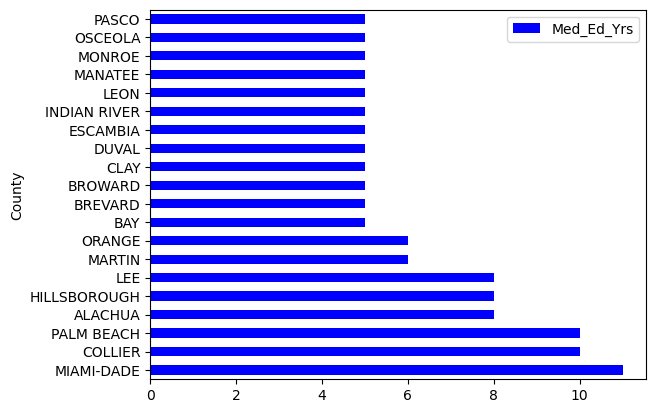

In [27]:
FL_df = FL_df.withColumnRenamed('CommercialData_AreaMedianEducationYears', 'Med_Ed_Yrs')
ed_yrs_by_cty_FL = FL_df.groupBy('County').agg(countDistinct('Med_Ed_Yrs')).orderBy('County')
ed_yrs_by_cty_FL = ed_yrs_by_cty_FL.withColumn('Med_Ed_Yrs', col('count(Med_Ed_Yrs)')).drop(col('count(Med_Ed_Yrs)'))
ed_yrs_by_cty_pd_FL = ed_yrs_by_cty_FL.toPandas()
top_20_ed_yrs_by_cty_pd_FL = ed_yrs_by_cty_pd_FL.nlargest(20, 'Med_Ed_Yrs')
top_20_ed_yrs_by_cty_pd_FL.plot(kind='barh', x='County', y='Med_Ed_Yrs', color='blue')

In [28]:
ed_yrs_by_cty_cnt_FL = ed_yrs_by_cty_FL.groupBy('Med_Ed_Yrs').agg(countDistinct('County')).orderBy('Med_Ed_Yrs')
ed_yrs_by_cty_cnt_FL.show()

+----------+-------------+
|Med_Ed_Yrs|count(County)|
+----------+-------------+
|         1|            1|
|         2|           17|
|         3|           14|
|         4|            8|
|         5|           19|
|         6|            2|
|         8|            3|
|        10|            2|
|        11|            1|
+----------+-------------+



In [29]:
ed_yr_turnout_FL = ed_yrs_by_cty_FL.join(voter_turnout_FL_CLEAN, 'County').orderBy('County').show()

+---------+----------+----------------+-------------------+-------------------+---------------------+
|   County|Med_Ed_Yrs|CountyTurnoutInt|CountyTurnoutDemInt|CountyTurnoutRepInt|CountyTurnoutOtherInt|
+---------+----------+----------------+-------------------+-------------------+---------------------+
|  ALACHUA|         8|              74|                 78|                 81|                   57|
|    BAKER|         2|              84|                 83|                 90|                   60|
|      BAY|         5|              75|                 74|                 85|                   54|
| BRADFORD|         3|              76|                 76|                 84|                   55|
|  BREVARD|         5|              78|                 79|                 86|                   63|
|  BROWARD|         5|              72|                 76|                 78|                   59|
|  CALHOUN|         2|              72|                 74|                 78|   

In [30]:
ed_lvl_combine = when(FL_df.CommercialData_Education.like('Grad Degree%'), 'Grad Degree')\
                .when(FL_df.CommercialData_Education.like('Bach Degree%'), 'Bach Degree')\
                .when(FL_df.CommercialData_Education.like('Vocational Technical Degree%'), 'Vocational Technical Degree')\
                .when(FL_df.CommercialData_Education.like('Some College%'), 'Some College')\
                .when(FL_df.CommercialData_Education.like('HS Diploma%'), 'HS Diploma')\
                .when(FL_df.CommercialData_Education.like('Less than HS Diploma%'), 'Less Than HS Diploma')\
                .otherwise('Null')
FL_df = FL_df.withColumn("Education_Lvl", ed_lvl_combine)

In [31]:
total_state_voters_FL = FL_df.select('LALVOTERID').count()
print('The total number of voters in the state of Florida:', total_state_voters_FL)

ed_lvl_st_cnt_FL = FL_df.groupBy(['Education_Lvl']).agg(countDistinct('LALVOTERID'))
ed_lvl_st_cnt_FL = ed_lvl_st_cnt_FL.withColumnRenamed('count(LALVOTERID)', 'num_voters')
ed_lvl_state_FL = ed_lvl_st_cnt_FL.withColumn('prcnt_of_total', round(((col('num_voters')/total_state_voters_FL)*100), 2))
ed_lvl_state_FL.show()

The total number of voters in the state of Florida: 14168189


+--------------------+----------+--------------+
|       Education_Lvl|num_voters|prcnt_of_total|
+--------------------+----------+--------------+
|Less Than HS Diploma|    422359|          2.98|
|          HS Diploma|   2345709|         16.56|
|         Bach Degree|   2317269|         16.36|
|         Grad Degree|   1180756|          8.33|
|Vocational Techni...|     14824|           0.1|
|        Some College|   1964463|         13.87|
|                Null|   5922809|          41.8|
+--------------------+----------+--------------+



<AxesSubplot:ylabel='Education_Lvl'>

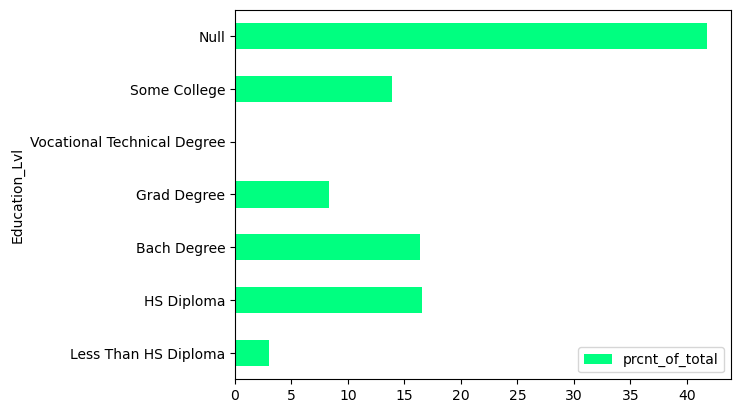

In [32]:
ed_lvl_state_pd_FL = ed_lvl_state_FL.toPandas()
ed_lvl_state_pd_FL.plot(kind='barh', x='Education_Lvl', y='prcnt_of_total', colormap='winter_r')

In [ ]:
county_voters_FL = FL_df.groupBy('County').agg(countDistinct('LALVOTERID'))
county_voters_FL = county_voters_FL.withColumn("voter_total", col('count(LALVOTERID)')).drop(col('count(LALVOTERID)')) 

ed_lvl_county_cnt_FL = FL_df.groupBy(['County','Education_Lvl']).agg(countDistinct('LALVOTERID'))
ed_lvl_county_cnt_FL = ed_lvl_county_cnt_FL.withColumn("ed_level_total", col('count(LALVOTERID)')).drop(col('count(LALVOTERID)')) 
ed_lvl_by_county_FL = ed_lvl_county_cnt_FL.join(county_voters_FL, 'County').orderBy('County')
ed_lvl_by_county_FL = ed_lvl_by_county_FL.withColumn("prcnt_of_total", round(((col("ed_level_total")/col("voter_total"))*100), 2))
ed_lvl_by_county_FL.show()

In [ ]:
## visualize distribution across counties for each level of education

## distribution of grad degrees per county
grad_dgs_by_county_FL = ed_lvl_by_county_FL.filter(ed_lvl_by_county_FL.Education_Lvl == "Grad Degree")
grad_dgs_by_county_pd_FL = grad_dgs_by_county_FL.toPandas()
top_20_grad_dgs_by_county_pd_FL = grad_dgs_by_county_pd_FL.nlargest(20, 'prcnt_of_total')
top_20_grad_dgs_by_county_pd_FL.plot.barh(x='County', y='prcnt_of_total', colormap='summer', title='Graduate Degree')

## distribution of bach degrees per county
bach_dgs_by_county_FL = ed_lvl_by_county_FL.filter(ed_lvl_by_county_FL.Education_Lvl == "Bach Degree")
bach_dgs_by_county_pd_FL = bach_dgs_by_county_FL.toPandas()
top_20_bach_dgs_by_county_pd_FL = bach_dgs_by_county_pd_FL.nlargest(20, 'prcnt_of_total')
top_20_bach_dgs_by_county_pd_FL.plot.barh(x='County', y='prcnt_of_total', colormap='magma', title='Bachelors Degree')

## distribution of vocational technical degrees per county
voc_dgs_by_county_FL = ed_lvl_by_county_FL.filter(ed_lvl_by_county_FL.Education_Lvl == "Vocational Technical Degree")
voc_dgs_by_county_pd_FL = voc_dgs_by_county_FL.toPandas()
top_20_voc_dgs_by_county_pd_FL = voc_dgs_by_county_pd_FL.nlargest(20, 'prcnt_of_total')
top_20_voc_dgs_by_county_pd_FL.plot.barh(x='County', y='prcnt_of_total', colormap='autumn', title='Vocational Technical Degree')

## distribution of some college per county
some_col_by_county_FL = ed_lvl_by_county_FL.filter(ed_lvl_by_county_FL.Education_Lvl == "Some College")
some_col_by_county_pd_FL = some_col_by_county_FL.toPandas()
top_20_some_col_by_county_pd_FL = some_col_by_county_pd_FL.nlargest(20, 'prcnt_of_total')
top_20_some_col_by_county_pd_FL.plot.barh(x='County', y='prcnt_of_total', colormap='twilight', title='Some College')

## distribution of hs diploma per county
hs_dip_by_county_FL = ed_lvl_by_county_FL.filter(ed_lvl_by_county_FL.Education_Lvl == "HS Diploma")
hs_dip_by_county_pd_FL = hs_dip_by_county_FL.toPandas()
top_20_hs_dip_by_county_pd_FL = hs_dip_by_county_pd_FL.nlargest(20, 'prcnt_of_total')
top_20_hs_dip_by_county_pd_FL.plot.barh(x='County', y='prcnt_of_total', colormap='ocean', title='High School Diploma')

## distribution of less than hs diploma per county
less_thn_hs_by_county_FL = ed_lvl_by_county_FL.filter(ed_lvl_by_county_FL.Education_Lvl == "Less Than HS Diploma")
less_thn_hs_by_county_pd_FL = less_thn_hs_by_county_FL.toPandas()
top_20_less_thn_hs_by_county_pd_FL = less_thn_hs_by_county_pd_FL.nlargest(20, 'prcnt_of_total')
top_20_less_thn_hs_by_county_pd_FL.plot.barh(x='County', y='prcnt_of_total', colormap='seismic', title='Less Than High School Diploma')

## distribution of null education level per county
null_ed_lvl_by_county_FL = ed_lvl_by_county_FL.filter(ed_lvl_by_county_FL.Education_Lvl == "Null")
null_ed_lvl_by_county_pd_FL = null_ed_lvl_by_county_FL.toPandas()
top_20_null_ed_lvl_by_county_pd_FL = null_ed_lvl_by_county_pd_FL.nlargest(20, 'prcnt_of_total')
top_20_null_ed_lvl_by_county_pd_FL.plot.barh(x='County', y='prcnt_of_total', colormap='spring', title='Null Values')